In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import math
import pandas as pd
%matplotlib inline
%pylab inline 
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [44]:
#Input do modelo

t=5 #tempo de propagacao
r=1 #custo do capital

P0=27 #preço do barril de petroleo inicial
u=3 #variação positiva do preço do petroleo
d=1/u #variação do preço negativa sendo o inverso da positiva
n=10 #fator de produção. Será substituido por uma curva de produção


I0=256 #Investimento inicial
s=3 #subida do investimento 
ins=1/s #variação negotiva sendo o inverso da subida do investimento



In [45]:
#Ativos de Arrow Debreu: Medida de não arbitragem ponderado por 1+r

#Matriz
U=np.array([[math.pow(u,2),math.pow(u,2),1,1],[math.pow(s,2),1,math.pow(s,2),1],[math.pow(u,2),math.pow((u*s),2),1,math.pow(s,2)],[1,1,1,1]])

#vetor A
A=np.array([[u],[s],[(u*s)],[(1/(1+r))]])


#Inversão
phi=np.linalg.solve(U,A)
phi_us=phi[0,0]
phi_ui=phi[1,0]
phi_ds=phi[2,0]
phi_di=phi[3,0]

phi



array([[ 0.2421875],
       [ 0.0703125],
       [ 0.0703125],
       [ 0.1171875]])

In [46]:
#Propagar Preços, Investimentos e VPL

m= np.array([[1,0,1,0],[1,0,0,1],[0,1,1,0],[0,1,0,1]], dtype='int64') #matriz base para propagação no tempo
V = np.zeros((pow(4,t),4)) # tamanho da matriz, a cada tempo t, das potencias a ser propagada
#V=np.zeros((pow(4,1),4),dtype='int64') # tamanho da matriz, em t=1, das potencias a ser propagada, em inteiros
P=np.zeros((pow(4,t),(t+1))) #matriz completa com zeros de P
P[0,0]=P0 #P0 na cela (0,0)
I=np.zeros((pow(4,t),(t+1))) #matriz completa com zeros de I
I[0,0]=I0 # IO na cela (0,0)

VPL=np.zeros((pow(4,t),(t+1))) #matriz completa com zeros de VPL
VPL[0,0]= max(P[0,0]*n - I[0,0],0)

for t0 in range (t):
    Vlast=V
    V=np.zeros((pow(4,t0+1),4), dtype='int64')
    k=0
    i=0
    while k< pow(4,t0+1):
        i=i+1
        for j in range(4):
            V[k,:]=Vlast[i-1,:]+m[j,:]
            P[k,t0+1]=P0*pow(u,V[k,0])*pow(d,V[k,1]) #Calculo dos Preços Futuros
            I[k,t0+1]=I0*pow(s,V[k,2])*pow(ins,V[k,3]) #Calculo dos Investimentos Futuros 
            VPL[k,t0+1]= max(0,P[k,t0+1]*n - I[k,t0+1])
            k=k+1

In [47]:
# Função Backwards Nesta Função Formamos a Opção no tempo e a Árvore de Decisao
F=np.zeros((pow(4,t),(t+1))) # A opção no tempo
F[:]=np.NaN
D=np.zeros((pow(4,t),(t+1)))  #Árvore de Decisao
D[:]=np.NaN
for i in range(pow(4,t)):  #O valor da opção em t=T é o valor do VPL calculado
    F[i,t]=VPL[i,t]
    if F[i,t] >0:
        D[i,t]=1 #Decisao de Investir
    else:
        D[i,t]=-1 #Decisao de Nao Investir
    

for j in range (t,0,-1): #o valor da opções em t<T é o máximo entre o VPL calculado e a opção deste ramo
    for i in range(pow(4,j-1)):
        F[i,j-1]=max (VPL[i,j-1],phi_us*F[(4*i),j]+ phi_ui*F[(4*i)+1,j]+phi_ds*F[(4*i)+2,j]+ phi_di*F[(4*i)+3,j])
        if F[i,j-1] == VPL[i,j-1] and VPL[i,j-1]!=0:
            D[i,j-1]=1 #Decisao 1 de Investir
        else:
            D[i,j-1]=0 #Decisao 0 de Esperar
        
        

In [48]:
VPL

array([[  1.40000000e+01,   4.20000000e+01,   1.26000000e+02,
          3.78000000e+02,   1.13400000e+03,   3.40200000e+03],
       [  0.00000000e+00,   7.24666667e+02,   2.17400000e+03,
          6.52200000e+03,   1.95660000e+04,   5.86980000e+04],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   8.94650206e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   5.76131687e-02]])

In [49]:
#Ajeitar a arvore de Decisao

for j in range(t):
    for i in range(pow(4,j)):
        if D[i,j]==1 or D[i,j]==np.NaN:
            D[(4*i),j+1]=np.NaN
            D[(4*i)+1,j+1]=np.NaN
            D[(4*i)+2,j+1]=np.NaN
            D[(4*i)+3,j+1]=np.NaN


In [50]:
# Criação do alinhamento das amostras Decisao
DA=np.zeros((pow(4,t),(t+1)))  
DA[:]=np.NaN
DA[:,t]=D[:,t]
for j in range(t,0,-1):
    for i in range(pow(4,j-1)):
        if i==0:
            DA[int((pow(4,t-(j-1)))/2)-1,j-1]=D[i,j-1]
        else:
            DA[int(i*(pow(4,t-(j-1)))+((pow(4,t-(j-1)))/2)-1),j-1]=D[i,j-1]

In [51]:
# Criação do alinhamento das amostras Decisao
PA=np.zeros((pow(4,t),(t+1)))  
PA[:]=np.NaN
PA[:,t]=P[:,t]
for j in range(t,0,-1):
    for i in range(pow(4,j-1)):
        if i==0:
            PA[int((pow(4,t-(j-1)))/2)-1,j-1]=P[i,j-1]
        else:
            PA[int(i*(pow(4,t-(j-1)))+((pow(4,t-(j-1)))/2)-1),j-1]=P[i,j-1]

In [52]:
# Criação do alinhamento das amostras VPL
VPLA=np.zeros((pow(4,t),(t+1)))  
VPLA[:]=np.NaN
VPLA[:,t]=VPL[:,t]
for j in range(t,0,-1):
    for i in range(pow(4,j-1)):
        if i==0:
            VPLA[int((pow(4,t-(j-1)))/2)-1,j-1]=VPL[i,j-1]
        else:
            VPLA[int(i*(pow(4,t-(j-1)))+((pow(4,t-(j-1)))/2)-1),j-1]=VPL[i,j-1]

In [53]:
# Criação do alinhamento das amostras F
FA=np.zeros((pow(4,t),(t+1)))  
FA[:]=np.NaN
FA[:,t]=F[:,t]
for j in range(t,0,-1):
    for i in range(pow(4,j-1)):
        if i==0:
            FA[int((pow(4,t-(j-1)))/2)-1,j-1]=F[i,j-1]
        else:
            FA[int(i*(pow(4,t-(j-1)))+((pow(4,t-(j-1)))/2)-1),j-1]=F[i,j-1]

In [54]:
# Criação do alinhamento das amostras I
IA=np.zeros((pow(4,t),(t+1)))  
IA[:]=np.NaN
IA[:,t]=I[:,t]
for j in range(t,0,-1):
    for i in range(pow(4,j-1)):
        if i==0:
            IA[int((pow(4,t-(j-1)))/2)-1,j-1]=I[i,j-1]
        else:
            IA[int(i*(pow(4,t-(j-1)))+((pow(4,t-(j-1)))/2)-1),j-1]=I[i,j-1]

0.0 167.534618334 14.0


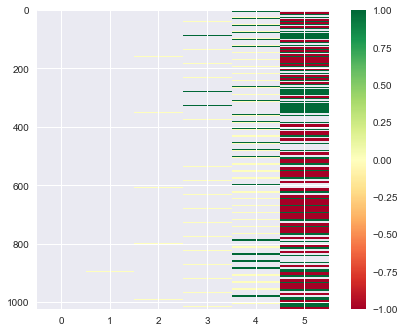

In [55]:
print(D[0,0],F[0,0], VPL[0,0])
imshow(DA,cmap='RdYlGn', aspect=0.006)  #Plot da Decisao
colorbar()

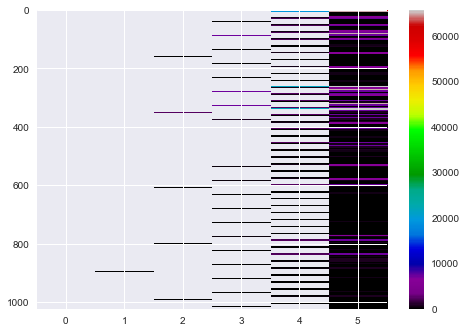

In [56]:
imshow(FA,cmap='nipy_spectral', aspect=0.005) #Plot do valor da Opcao
colorbar()
plt.show()

In [57]:
#dataframe dos precos organizados
Pdf=pd.DataFrame(PA)

In [58]:
#dataframe dos investimento organizados organizados
Idf=pd.DataFrame(IA)

In [59]:
#dataframe dos vpls organizados organizados
VPLdf=pd.DataFrame(VPLA)

In [60]:
#dataframe dos investimento organizados organizados
Fdf=pd.DataFrame(FA)

In [61]:
#dataframe das Decisoes organizados organizadas

Ddf=pd.DataFrame(DA)

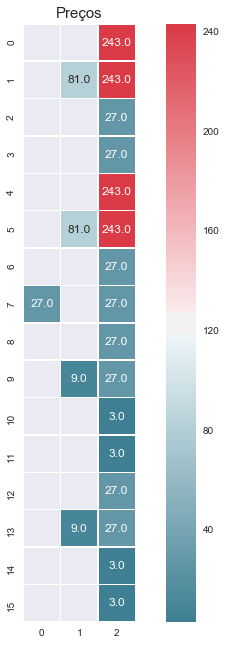

In [36]:
#OS PRECOS
plt.figure(figsize=(11,11))
plt.title('Preços', size = 15)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(Pdf, annot=True, fmt=".1f", linewidths=.5, square = True, cmap =cmap)

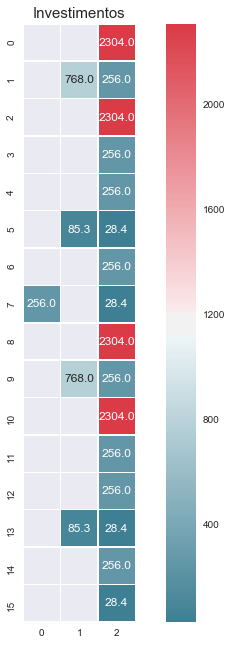

In [37]:
#OS INVESTIMENTOS
plt.figure(figsize=(11,11))
plt.title('Investimentos', size = 15)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(Idf, annot=True, fmt=".1f", linewidths=.5, square = True, cmap =cmap);

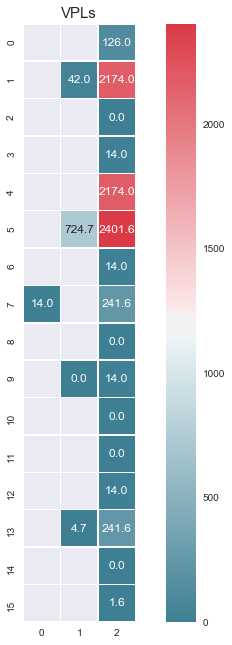

In [38]:
#OS VPLs
plt.figure(figsize=(11,11))
plt.title('VPLs', size = 15)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(VPLdf, annot=True, fmt=".1f", linewidths=.5, square = True, cmap =cmap);

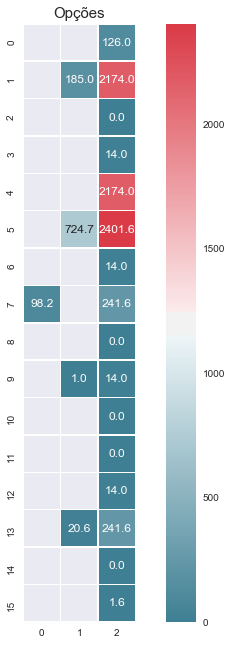

In [39]:
#AS OPCOES
plt.figure(figsize=(11,11))
plt.title('Opções', size = 15)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(Fdf, annot=True, fmt=".1f", linewidths=.5, square = True, cmap =cmap);

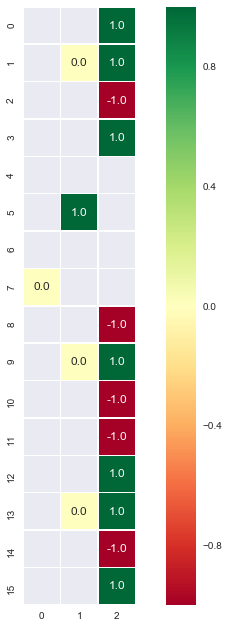

In [43]:
#AS Decisoes
plt.figure(figsize=(11,11))
#plt.title('Decisões', size = 15)
sns.heatmap(Ddf,annot=True, fmt=".1f", linewidths=.5, square = True, cmap ='RdYlGn');

In [63]:
Ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 6 columns):
0    1 non-null float64
1    4 non-null float64
2    16 non-null float64
3    64 non-null float64
4    240 non-null float64
5    732 non-null float64
dtypes: float64(6)
memory usage: 48.1 KB
